In [1]:
from datetime import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   pandas.plotting import register_matplotlib_converters
import seaborn as sns
from   sklearn.metrics import r2_score 
from   sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from   tensorflow.keras.callbacks import ModelCheckpoint
from   tensorflow.keras.layers import Dense, Dropout, Input
from   tensorflow.keras.models import load_model, Model
from   tensorflow.keras.optimizers import SGD

register_matplotlib_converters()
%matplotlib inline

In [2]:
DATA = '../../../data'

In [3]:
df = pd.read_csv(f'{DATA}/beijingAirPollution.csv')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
dt = []
for _, (year, month, day, hour) in df[['year', 'month', 'day', 'hour']].iterrows():
    dt.append(datetime(year=year, month=month, day=day, hour=hour))

In [5]:
df['datetime'] = dt
df.sort_values('datetime', inplace=True)
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


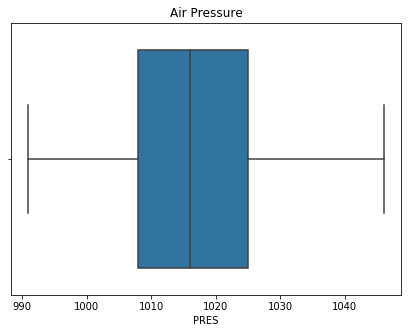

In [6]:
plt.figure(figsize=(7, 5))
g = sns.boxplot(df.PRES)
g.set_title('Air Pressure');

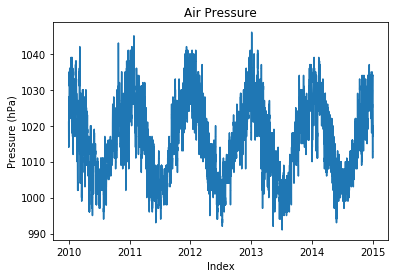

In [7]:
g = sns.lineplot(x=df['datetime'], y=df.PRES)
g.set_title('Air Pressure')
g.set_xlabel('Index')
g.set_ylabel('Pressure (hPa)');

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(
    np.array(df.PRES).reshape(-1, 1))

In [9]:
split_date = datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime'] < split_date]
df_val = df.loc[df['datetime'] >= split_date]
df_train.shape, df_val.shape

((35064, 15), (8760, 15))

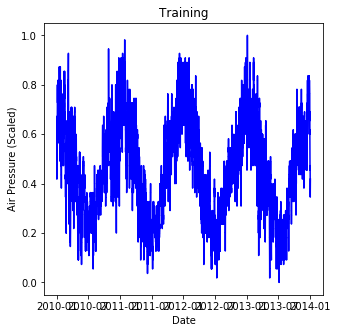

In [10]:
plt.figure(figsize=(5, 5))
g = sns.lineplot(df_train['datetime'], df_train.scaled_PRES, color='b')
g.set_title('Training')
g.set_xlabel('Date')
g.set_ylabel('Air Pressure (Scaled)');

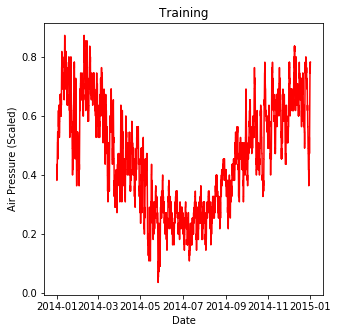

In [11]:
plt.figure(figsize=(5, 5))
g = sns.lineplot(df_val['datetime'], df_val.scaled_PRES, color='r')
g.set_title('Training')
g.set_xlabel('Date')
g.set_ylabel('Air Pressure (Scaled)');

In [12]:
def make_xy(ts, n_timesteps):
    ts.index = range(ts.shape[0])
    X = []
    y = []
    for i in range(n_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i - n_timesteps:i - 1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [13]:
X_train, y_train = make_xy(df_train['scaled_PRES'], 7)

In [14]:
X_val, y_val = make_xy(df_val.scaled_PRES, 7)
for d in [X_train, y_train, X_val, y_val]:
    print(d.shape)

(35057, 7)
(35057,)
(8753, 7)
(8753,)


In [15]:
input_layer = Input(shape=(7,), dtype='float32')
d1 = Dense(32, activation='relu')(input_layer)
d2 = Dense(16, activation='relu')(d1)
d3 = Dense(16, activation='relu')(d1)
drop = Dropout(0.2)(d3)
output_layer = Dense(1, activation='linear')(drop)

In [16]:
ts_mod = Model(inputs=input_layer, outputs=output_layer)
ts_mod.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
ts_mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [18]:
save_weights_at = 'AirPressure_weights_e{epoch}_loss{val_loss:.4f}.hdf5'
save_best = ModelCheckpoint(save_weights_at, 
                            monitor='val_loss', 
                            save_best_only=True, 
                            save_weights_only=False, 
                            mode='min', 
                            period=1)
ts_mod.fit(X_train, 
           y_train, 
           batch_size=16, 
           epochs=20,
           callbacks=[save_best], 
           validation_data=(X_val, y_val), 
           shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 4s 110us/sample - loss: 0.0069 - val_loss: 4.5756e-04
Epoch 2/20
35057/35057 [==============================] - 3s 83us/sample - loss: 0.0024 - val_loss: 5.8630e-04
Epoch 3/20
35057/35057 [==============================] - 3s 83us/sample - loss: 0.0024 - val_loss: 3.4283e-04
Epoch 4/20
35057/35057 [==============================] - 3s 84us/sample - loss: 0.0020 - val_loss: 3.2473e-04
Epoch 5/20
35057/35057 [==============================] - 3s 83us/sample - loss: 0.0019 - val_loss: 3.0477e-04
Epoch 6/20
35057/35057 [==============================] - 3s 83us/sample - loss: 0.0018 - val_loss: 3.1602e-04
Epoch 7/20
35057/35057 [==============================] - 3s 83us/sample - loss: 0.0018 - val_loss: 2.7546e-04
Epoch 8/20
35057/35057 [==============================] - 3s 84us/sample - loss: 0.0018 - val_loss: 2.5884e-04
Epoch 9/20
35057/35057 [==============================] - 3s 8

In [19]:
!ls .

AirPressure_weights_e12_loss0.0002.hdf5 AirPressure_weights_e5_loss0.0003.hdf5
AirPressure_weights_e14_loss0.0002.hdf5 AirPressure_weights_e7_loss0.0003.hdf5
AirPressure_weights_e1_loss0.0005.hdf5  AirPressure_weights_e8_loss0.0003.hdf5
AirPressure_weights_e3_loss0.0003.hdf5  AirPressure_weights_e9_loss0.0002.hdf5
AirPressure_weights_e4_loss0.0003.hdf5  ffnn_for_ts_forecasting.py.ipynb


In [21]:
best_mod = load_model('AirPressure_weights_e14_loss0.0002.hdf5')
preds = best_mod.predict(X_val)

In [22]:
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)
pred_PRES

array([1011.90045, 1013.02625, 1013.5483 , ..., 1033.7498 , 1033.471  ,
       1033.4437 ], dtype=float32)

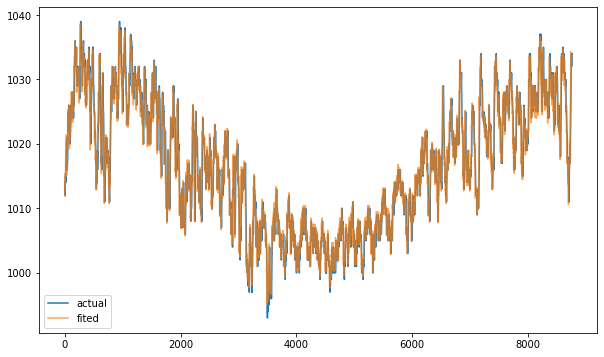

In [23]:
plt.figure(figsize=(10, 6))
t1 = range(8760)
t2 = range(8753)
plt.plot(t1, df_val.PRES, label='actual')
plt.plot(t2, pred_PRES, alpha=0.7, label='fited')
plt.legend();

In [24]:
r2 = r2_score(df_val.loc[35071:, 'PRES'], pred_PRES) 
print('R-squared for the validation set:', round(r2, 4))

R-squared for the validation set: 0.995
